In [12]:
from sentence_transformers import SentenceTransformer, util
import numpy as np
import torch
import re
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from langchain.document_loaders import TextLoader
from langchain.text_splitter import CharacterTextSplitter, RecursiveCharacterTextSplitter, NLTKTextSplitter
from langchain.embeddings.openai import OpenAIEmbeddings
from langchain.vectorstores import Chroma
from sentence_transformers import SentenceTransformer
from langchain.embeddings import GPT4AllEmbeddings

file_name = "DarazDataSeller.txt"
search_query = "Can I make product bundles on Daraz?"
search_query = re.sub(r'\bDaraz\b\s*', '', search_query, flags=re.IGNORECASE)
chunkSize = 1500

with open(file_name, 'r', encoding="utf8") as f:
    products = f.readlines()

In [13]:
model = SentenceTransformer('all-MiniLM-L6-v2')
product_embeddings = model.encode(products, convert_to_tensor=True)

def search_products(query, k):
    query_embedding = model.encode(query, convert_to_tensor=True)
    cosine_scores = util.pytorch_cos_sim(query_embedding, product_embeddings)[0]
    top_results = torch.topk(cosine_scores, k=k)

    print("Query:", query)
    for score, idx in zip(top_results[0], top_results[1]):
        print("\nScore:", score.item())
        print("Product Details:", products[idx])

search_products(search_query, 2)

Query: Can I make product bundles on ?

Score: 0.6566495895385742
Product Details: Why should I create bundles? Sellers can create bundles to differentiate their deals from competitors, especially in high-priced competitive categories It's a great opportunity to sell low-cost items as part of a bundle Bundles allow sellers to clear their inventory of whatever products they choose Additionally, bundles are a foolproof way to attract customers and increase conversion rate, sales and enhance overall performance.


Score: 0.6418728828430176
Product Details: What are the Benefits of creating Product Bundles? Sellers can create bundles to differentiate their deals from competitors, especially in high-priced competitive categories It’s a great opportunity to sell low cost items as part of a bundle Bundles allow Sellers to clear their inventory of whatever products they choose Additionally, bundles are a full proof way to attract customers and increase conversion rate, sales and enhance overal

In [14]:
query = search_query
loader = TextLoader(file_name)
docs = loader.load()

In [15]:
chunker01 = "Fixed-size (in characters) Overlapping Sliding Window"

text_splitter = CharacterTextSplitter(separator="\n", chunk_size=chunkSize, chunk_overlap=20)
splits = text_splitter.split_documents(docs)

persist_directory = 'chroma/' + str(file_name) + " - Chunker = " + chunker01
vectordb = Chroma.from_documents(
    documents=splits,
    embedding=GPT4AllEmbeddings(),
    persist_directory=persist_directory
)
vectordb.persist()
docs01 = vectordb.similarity_search_with_score(query, k=2)

Created a chunk of size 2262, which is longer than the specified 1500
Created a chunk of size 7956, which is longer than the specified 1500
Created a chunk of size 2841, which is longer than the specified 1500
Created a chunk of size 2920, which is longer than the specified 1500
Created a chunk of size 2399, which is longer than the specified 1500
Created a chunk of size 1538, which is longer than the specified 1500
Created a chunk of size 1731, which is longer than the specified 1500
Created a chunk of size 2714, which is longer than the specified 1500
Created a chunk of size 1561, which is longer than the specified 1500
Created a chunk of size 1916, which is longer than the specified 1500
Created a chunk of size 1642, which is longer than the specified 1500
Created a chunk of size 2868, which is longer than the specified 1500
Created a chunk of size 1639, which is longer than the specified 1500
Created a chunk of size 1594, which is longer than the specified 1500
Created a chunk of s

In [16]:
chunker02 = "Recursive Structure Aware Splitting"

text_splitter = RecursiveCharacterTextSplitter(separators = ["\n\n", "\n"], chunk_size=chunkSize, chunk_overlap=20)
splits = text_splitter.split_documents(docs)

persist_directory = 'chroma/' + str(file_name) + " - Chunker = " + chunker02
vectordb = Chroma.from_documents(
    documents=splits,
    embedding=GPT4AllEmbeddings(),
    persist_directory=persist_directory
)
vectordb.persist()
docs02 = vectordb.similarity_search_with_score(query, k=2)

In [17]:
chunker03 = "NLP Chunking: Tracking Topic Changes"

text_splitter = NLTKTextSplitter(chunk_size=chunkSize)#, separator="\n")
splits = text_splitter.split_documents(docs)

persist_directory = 'chroma/' + str(file_name) + " - Chunker = " + chunker03
vectordb = Chroma.from_documents(
    documents=splits,
    embedding=GPT4AllEmbeddings(),
    persist_directory=persist_directory
)
vectordb.persist()
docs03 = vectordb.similarity_search_with_score(query, k=2)

In [18]:
print("question = \"" + query + "\"")

with open("outputSeller.txt", "w") as file:
    count = 1
    for result in docs01:
        file.write(f"response{count} = \"{result[0].page_content}\"\n")
        count += 1

    count = 1
    for result in docs02:
        file.write(f"response{count} = \"{result[0].page_content}\"\n")
        count += 1

    count = 1
    for result in docs03:
        file.write(f"response{count} = \"{result[0].page_content}\"\n")
        count += 1

question = "Can I make product bundles on ?"


In [19]:
import re
import textwrap

def clean_text(text):
    # Remove any image file references
    text = re.sub(r"\S+\.(png|jpg|jpeg|gif)\s*", "", text)

    # Normalize spacing issues
    text = re.sub(r"\s+", " ", text).strip()

    # Correct common typographical errors
    text = re.sub(r"isnot", "is not", text)
    text = re.sub(r"orBrand", "or Brand", text)
    text = re.sub(r"ourWarranty", "our Warranty", text)

    # Remove redundant response indicators
    text = re.sub(r"response\d+\s*=\s*\"", "", text)

    # Remove numbers followed by a dot, e.g., "1."
    text = re.sub(r"\d+\.", "", text)

    # Remove numbers followed directly by a dash, e.g., "2-"
    text = re.sub(r"\d+-", "", text)

    # Deduplicate text
    lines = text.split('.')
    seen = set()
    unique_lines = []
    for line in lines:
        line_clean = line.strip()
        if line_clean not in seen:
            seen.add(line_clean)
            unique_lines.append(line_clean)

    # Reconstruct text with clean lines
    cleaned_text = '. '.join(unique_lines).strip()
    if not cleaned_text.endswith('.'):
        cleaned_text += '.'

    # Split into multiple lines with a reasonable width
    wrapped_text = textwrap.fill(cleaned_text, width=100)

    return wrapped_text

with open('outputSeller.txt', 'r') as file:
    raw_text = file.read()
    
cleaned_text = clean_text(raw_text)

with open('outputSeller.txt', 'w') as file:
    file.write(cleaned_text)

In [20]:
loader = TextLoader("outputSeller.txt")
docs = loader.load()

text_splitter = CharacterTextSplitter(separator="\n", chunk_size=chunkSize, chunk_overlap=0)
splits = text_splitter.split_documents(docs)

persist_directory = 'chroma/' + str(file_name) + " - On Final Clean Output"
vectordb = Chroma.from_documents(
    documents=splits,
    embedding=GPT4AllEmbeddings(),
    persist_directory=persist_directory
)
vectordb.persist()
docs = vectordb.similarity_search_with_score(query, k=2)

In [21]:
print("question = \"" + query + "\"")
count = 1
for result in docs:
    print(f"response" + str(count) + " = \"" + result[0].page_content + "\"")  
    count+=1

question = "Can I make product bundles on ?"
response1 = "market research" What are the types of Product Bundling? Note: Only one type of bundle feature can
be activated at a single time for a particular SKU. Minimum 5 customs products should be there if a
seller is selling only custom made products What are the Benefits of Product Customization? Match
Customer Demand Increase sales and competitive edge Customer engagement Build brand loyalty Gain
market research" It increases your customer’s trust and will help you get a higher seller rating. It
reduces the rejection rate and returns rate thanks to product knowledge. What is the bundles return
policy? Customers must return all bundle products in order for the return to be processed. Returns
claims will not be accepted for incomplete bundles. Why should I create bundles? Sellers can create
bundles to differentiate their deals from competitors, especially in high-priced competitive
categories It's a great opportunity to sell low-cost it

In [22]:
# with open('output.txt', 'r') as file:
#     content = file.readlines()

![Screenshot 2024-04-26 at 9.06.54 PM.jpeg](<attachment:Screenshot 2024-04-26 at 9.06.54 PM.jpeg>)
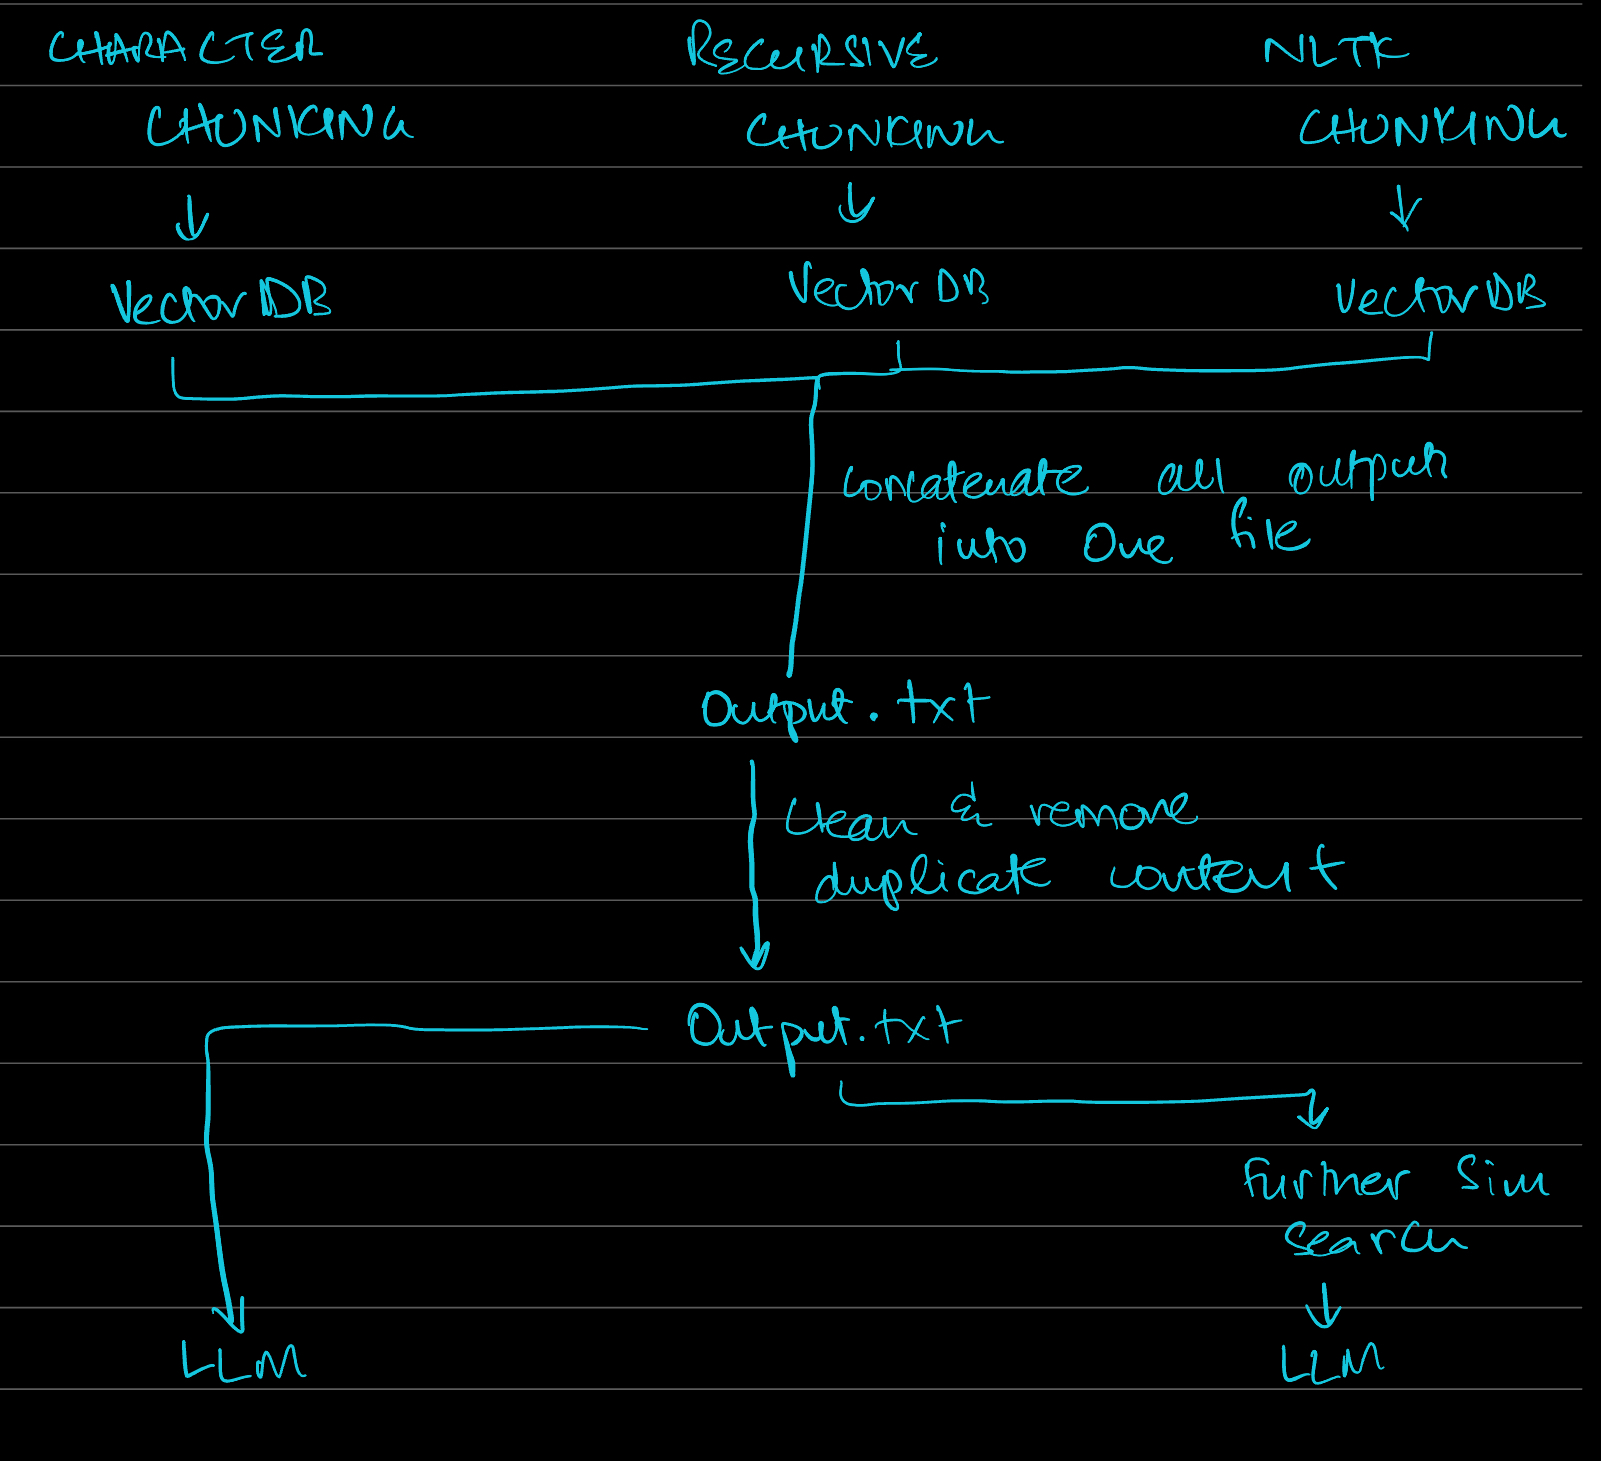